In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import PIL
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [2]:
# load image list
path = os.path.join('D:\\','OneDrive - Northwestern University','Photos', 'bubbleimages')
bubnum = pd.read_csv(os.path.join(path, 'bubnums.csv'), names=['event', 'nbub'])
bubnum = np.array(bubnum)

In [3]:
# # produce diff files trig frame and the next one
# row = bubnum[0]
# for row in bubnum:
#     try: 
#         img = Image.open(os.path.join(path, 'trig', row[0]+'_trig.bmp'))
#         nextimg = Image.open(os.path.join(path, 'next', row[0]+'_next.bmp'))
#         diff = PIL.ImageChops.invert(PIL.ImageChops.difference(img, nextimg))
#         diff.save(os.path.join(path,'diff',row[0]+'_diff.bmp'))
#         img.close()
#         nextimg.close()
#         diff.close()
#     except FileNotFoundError: continue

# # from trig frame and first frame of the event
# for row in bubnum:
#     try: 
#         img = Image.open(os.path.join(path, 'trig', row[0]+'_trig.bmp'))
#         firstimg = Image.open(os.path.join(path, 'first', row[0]+'_first.bmp'))
#         diff = PIL.ImageChops.invert(PIL.ImageChops.difference(img, firstimg))
#         diff.save(os.path.join(path,'difffirst',row[0]+'_difffirst.bmp'))
#         img.close()
#         firstimg.close()
#         diff.close()
#     except FileNotFoundError: continue

In [4]:
# get the distribution of bubbles from events with images
for i in range(5):
    print("Number of events with %d bubbles: %d"%(i,np.sum(bubnum[:,1]==i)))

Number of events with 0 bubbles: 17364
Number of events with 1 bubbles: 7057
Number of events with 2 bubbles: 260
Number of events with 3 bubbles: 15
Number of events with 4 bubbles: 1


In [5]:
# define function to load images
def load_diff(event):
    img = Image.open(os.path.join(path, 'diff', event+'_diff.bmp'))
    arr = np.asarray(PIL.ImageChops.invert(img))
    img.close()
    return arr

def load_difffirst(event):
    img = Image.open(os.path.join(path, 'difffirst', event+'_difffirst.bmp'))
    arr = np.asarray(PIL.ImageChops.invert(img))
    img.close()
    return arr

def load_trig(event):
    img = Image.open(os.path.join(path, 'trig', event+'_trig.bmp'))
    arr = np.asarray(img)
    img.close()
    return arr

def load_next(event):
    img = Image.open(os.path.join(path, 'next', event+'_next.bmp'))
    arr = np.asarray(img)
    img.close()
    return arr

def load_first(event):
    img = Image.open(os.path.join(path, 'first', event+'_first.bmp'))
    arr = np.asarray(img)
    img.close()
    return arr

In [6]:
# define functions to normalize image
def normalize(arr):
    arr = np.array(arr)
    arr = arr - np.min(arr)
    arr = arr / np.max(arr)
    return np.array(arr)

def gaussian_normalize(arr):
    arr = np.array(arr)
    arr = arr - np.mean(arr)
    arr = arr / np.std(arr)
    return np.array(arr)

In [7]:
# define functions to pad an image or a patch for convolution
def pad_left(arr, n):
    nrow, ncol = arr.shape
    if n<=0: return arr[:,-n:]
    ret = np.array([[None for j in range(ncol+n)] for i in range(nrow)])
    ret[:,n:ncol+n] = arr
    ret[:,:n] = np.transpose([arr[:,0] for i in range(n)])
    return ret

def pad_right(arr, n):
    nrow, ncol = arr.shape
    if n<=0: return arr[:,:ncol+n]
    ret = np.array([[None for j in range(ncol+n)] for i in range(nrow)])
    ret[:,:ncol] = arr
    ret[:,ncol:ncol+n] = np.transpose([arr[:,-1] for i in range(n)])
    return ret

def pad_top(arr, n):
    nrow, ncol = arr.shape
    if n<=0: return arr[-n:,:]
    ret = np.array([[None for j in range(ncol)] for i in range(nrow+n)])
    ret[n:nrow+n,:] = arr
    ret[:n,:] = np.array([arr[0,:] for i in range(n)])
    return ret

def pad_bottom(arr, n):
    nrow, ncol = arr.shape
    if n<=0: return arr[:nrow+n,:]
    ret = np.array([[None for j in range(ncol)] for i in range(nrow+n)])
    ret[:nrow,:] = arr
    ret[nrow:nrow+n,:] = np.array([arr[-1,:] for i in range(n)])
    return ret

def pad_image(arr, kshape):
    # take a 2-D array, return a padded 2-D array
    # negative pad means taking off rows or columns at a side
    ntop, nbottom = kshape[0]//2, (kshape[0]+1)//2
    nleft, nright = kshape[1]//2, (kshape[1]+1)//2
    arr = np.array(arr)
    arr = pad_left(arr, nleft)
    arr = pad_right(arr, nright)
    arr = pad_top(arr, ntop)
    arr = pad_bottom(arr,nbottom)
    return np.array(arr)

In [8]:
# convolution over an image
def convolve(arr, k, step=1):
    ret = []
    k = np.array(k)
    arr = pad_image(arr, k.shape)
    nrow, ncol = arr.shape
    krow, kcol = k.shape
    for i in range(0, nrow-krow, step):
        row = []
        for j in range(0, ncol-kcol, step):
            patch = arr[i:i+krow, j:j+kcol]
            value = np.tensordot(patch,k)
            row.append(value)
        ret.append(np.array(row))
    return np.array(ret).astype(type(arr[0,0]))

In [9]:
# process image and run the average filter over an image
def process_image(event):
    # open image
    img = Image.open(os.path.join(path, 'difffirst', event+'_difffirst.bmp'))
    arr = np.asarray(PIL.ImageChops.invert(img))
    img.close()
    
    # run convolution of 5*5 average filter
    kavg = np.ones([5,5])/5**2
    return  convolve(arr, kavg, 1)

In [10]:
# load a random event and display a trig, diff, and feature frames with number of bubbles
def load_random_event(nbub=0):
    ev = np.random.choice(bubnum[:,0][bubnum[:,1]==nbub])
    print(ev, '\tnbub:', bubnum[np.argwhere(bubnum[:,0]==ev)][0,0,1])

    fig, ax = plt.subplots(figsize=(12,10))

    arrtrig = load_trig(ev)
    plt.subplot(221)
    plt.imshow(arrtrig, cmap='gray')
    plt.title("Trigger")
    plt.axis('off')

    arrdiff = load_diff(ev)
    plt.subplot(222)
    plt.imshow(arrdiff, cmap='gray_r')
    plt.title("Difference")
    plt.axis('off')

    arravg = process_image(ev)
    plt.subplot(223)
    plt.imshow(arravg, cmap='gray_r')
    plt.title("Averaged")
    plt.axis('off')

    arrfirst = load_difffirst(ev)
    plt.subplot(224)
    plt.imshow(arrfirst, cmap='gray_r')
    plt.title("Diff First")
    plt.axis('off')

    fig.tight_layout()
    plt.show()
    return

20170924_0_27 	nbub: 1


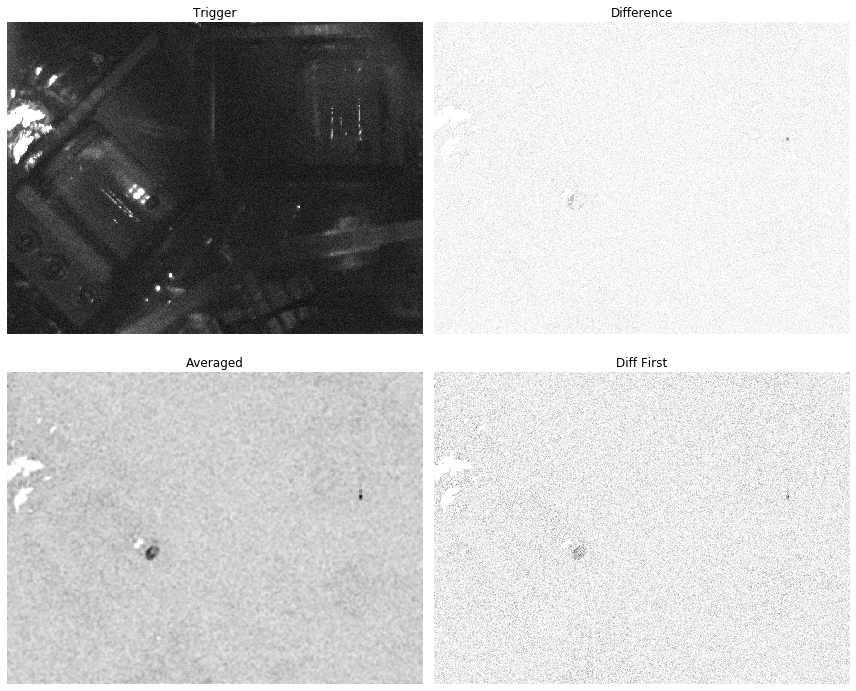

In [13]:
load_random_event(1)

In [12]:
# get min, max, and mean, std of pixel values for all events with a certain load function (trig, diff, etc.)
def min_max_helper(load_func, event):
    arr = load_func(event)
    return np.size(arr), np.sum(arr), np.sum(arr**2), np.min(arr), np.max(arr)

def get_min_max(load_func):
    allarr = np.array([min_max_helper(load_func, ev) for ev in bubnum[:,0]])
    n = np.sum(allarr[:,0])
    mean = np.sum(allarr[:,1])/n
    std = np.sqrt(np.abs((np.sum(allarr[:,2])/(n-1)) - (mean**2)))
    minval = np.min(allarr[:,3])
    maxval = np.max(allarr[:,4])
    print("%s\nmin: \t%d\tmax: \t%d\nmean: \t%.3f\tstd: \t%.3f"%(load_func.__name__[5:], minval, maxval, mean, std))
    return minval, maxval, mean, std

# for func in [load_trig, load_next, load_first, load_diff, load_difffirst]:
#     t = time.time()
#     get_min_max(func)
#     print("Time used:\t%.3fs\n"%(time.time()-t))

trig
min: 	0	max: 	255
mean: 	46.893	std: 	45.615
Time used:	40.716s

next
min: 	0	max: 	255
mean: 	46.879	std: 	45.600
Time used:	40.484s

first
min: 	0	max: 	255
mean: 	46.923	std: 	45.646
Time used:	126.712s

diff
min: 	0	max: 	236
mean: 	9.704	std: 	4.982
Time used:	352.881s

difffirst
min: 	0	max: 	244
mean: 	9.672	std: 	4.944
Time used:	353.924s

